In [1]:
import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# modeling imports
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV # Linear Regression Model
from sklearn.preprocessing import StandardScaler#Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error #model evaluation

from sklearn.model_selection import train_test_split,KFold,LeaveOneOut
# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

# Review

## The Bias Variance Tradeoff

$$ \underbrace{E(y_0 - \hat{f}(x_0))^2}_\text{expected MSE at $x_0$} = \overbrace{Var(\hat{f}(x_0))}^\text{variance of the model when fit on different samples} + \underbrace{[Bias(\hat{f}(x_0))]^2}_\text{ability of the model to "get it right" on average} + \overbrace{Var(\epsilon)}^\text{irreducible error}$$

<img src="https://drive.google.com/uc?export=view&id=1akEMD7_STAkqJcZUI5vc3CW5aU5AeTWR" alt="Q" width = 500px/>'

### Overfitting
**What is Overfitting and underfitting?**

Answer: In overfitting, the model learns the training data too closely, including noise, so it performs poorly on new data. With underfitting, the model is too simple to capture patterns, so it performs poorly on both training and new data.

**What are we looking for when trying to see if there is overfitting?**

Answer: When looking for overfitting, we look for a big gap between the training and validation errors. This is where the model does well on training data but much worse on unseen data.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = 200px/>


## Model Validation

We learned about 3 types of model validation that help us estimate how well our model might do on data it has never seen before.

- **Train Test Split (TTS)**: We take our data and break it up into two groups, training (used to fit model) and testing (used to see how the model does on data it has never seen before)
- **K-Fold Cross Validation (KF)**: We take our data and break it up into K groups. We train K different models using a different group as the test set each time. The other K-1 groups are used to train the model.
- **Leave One Out Cross Validation (LOO)**: Like K-Fold but each data point is it's own fold. This means we fit N models (where N is the number of data points) using N-1 data points to train, and 1 data point to test.


Remember the purpose of a test set is to be UNSEEN data. We should NEVER fit ANYTHING on the test set. In fact we should not even TOUCH the test set until our model is completely done training.

Let's modify the code building a Linear Regression to predict `Amazon Price` to include model validation.

### Train Test Split

In [2]:
# Train Test Split
# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# validation

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# assess
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))

Train MSE :  10.260987892001578
Train MAE :  2.1982444163553327
Train MAPE:  0.2026652477509323
Train R2  :  0.9207676460859384
Test MSE  :  15.2235371411616
Test MAE  :  2.6386542444219447
Test MAPE :  0.23705045691435547
Test R2   :  0.8984177286673536


### K-Fold

In [3]:
# K-Fold

# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# validation
kf = KFold(5)

mse = {"train": [], "test": []}
mae = {"train": [], "test": []}


for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]

    # fit
    pipe.fit(X_train,y_train)

    # predict
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # assess
    mse["train"].append(mean_squared_error(y_train,y_pred_train))
    mse["test"].append(mean_squared_error(y_test,y_pred_test))

    mae["train"].append(mean_absolute_error(y_train,y_pred_train))
    mae["test"].append(mean_absolute_error(y_test,y_pred_test))

print("Train MSEs:", mse["train"])
print("Test MSEs :", mse["test"])
print("Train MSE :", np.mean(mse["train"]))
print("Test MSE  :", np.mean(mse["test"]))

Train MSEs: [10.98399505558313, 7.941221786054292, 11.794945195589262, 11.51811581009875, 10.005246422825257]
Test MSEs : [10.296504891132065, 23.091879305186016, 5.990062542275865, 7.32277073168467, 14.526081589875584]
Train MSE : 10.448704854030138
Test MSE  : 12.24545981203084


### Leave One Out

In [4]:
# Leave One Out

# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# validation
kf = LeaveOneOut()

mse = {"train": [], "test": []}
mae = {"train": [], "test": []}


for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]

    # fit
    pipe.fit(X_train,y_train)

    # predict
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # assess
    mse["train"].append(mean_squared_error(y_train,y_pred_train))
    mse["test"].append(mean_squared_error(y_test,y_pred_test))

    mae["train"].append(mean_absolute_error(y_train,y_pred_train))
    mae["test"].append(mean_absolute_error(y_test,y_pred_test))


#print("Train MSEs:", mse["train"])
#print("Test MSEs :", mse["test"])
print("Train MSE :", np.mean(mse["train"]))
print("Test MSE  :", np.mean(mse["test"]))

Train MSE : 10.607837802895082
Test MSE  : 13.849156185219838



### Assumption Checks with TTS, KF, LOO
Creating a residual plot requires we have residuals, which requires a model. Check assumptions *after* fitting the model by making residual plot(s).



In [5]:
# Train Test Split
# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# validation

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# assump
assump_train = pd.DataFrame({"predicted": y_pred_train,
                        "errors": y_train - y_pred_train})

print(ggplot(assump_train, aes(x = "predicted", y = "errors")) +
geom_point() +
theme_minimal() +
geom_hline(yintercept = 0, color = "red", linetype = "dashed"))


# assess
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))

<ggplot: (640 x 480)>
Train MSE :  11.47151975337698
Train MAE :  2.190932956618368
Train MAPE:  0.19540247536589547
Train R2  :  0.9216243120894689
Test MSE  :  7.462519401007258
Test MAE  :  2.1522419009120037
Test MAPE :  0.2109003420694809
Test R2   :  0.9097228843638455


In [6]:
# K-Fold

# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# validation
kf = KFold(5)

mse = {"train": [], "test": []}
mae = {"train": [], "test": []}


for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]

    # fit
    pipe.fit(X_train,y_train)

    # predict
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # assump
    assump_train = pd.DataFrame({"predicted": y_pred_train,
                            "errors": y_train - y_pred_train})

    print(ggplot(assump_train, aes(x = "predicted", y = "errors")) +
    geom_point() +
    theme_minimal() +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed"))


    # assess
    mse["train"].append(mean_squared_error(y_train,y_pred_train))
    mse["test"].append(mean_squared_error(y_test,y_pred_test))

    mae["train"].append(mean_absolute_error(y_train,y_pred_train))
    mae["test"].append(mean_absolute_error(y_test,y_pred_test))

print("Train MSEs:", mse["train"])
print("Test MSEs :", mse["test"])
print("Train MSE :", np.mean(mse["train"]))
print("Test MSE  :", np.mean(mse["test"]))

<ggplot: (640 x 480)>
<ggplot: (640 x 480)>
<ggplot: (640 x 480)>
<ggplot: (640 x 480)>
<ggplot: (640 x 480)>
Train MSEs: [10.98399505558313, 7.941221786054292, 11.794945195589262, 11.51811581009875, 10.005246422825257]
Test MSEs : [10.296504891132065, 23.091879305186016, 5.990062542275865, 7.32277073168467, 14.526081589875584]
Train MSE : 10.448704854030138
Test MSE  : 12.24545981203084


### Computational Time
TTS, KF, and LOO all aim to estimate the same thing: how a model will perform on unseen data, but they aren't necessarily equivalent (as you'll explore below). I mentioned in lecture that two major things you may want to think about when choosing a method of model validation are *computational expense of the model* and *the size of your dataset*.

Some students always prefer to the use of TTS by saying that they were worried about computational expense. However,  except for extremely large datasets (we're talking 100's of thousands of rows), or incredibly complex models (which we won't really touch until the very end), in our class, computational expense between TTS and KF is often negligible and a weak argument for justifying TTS over KF/LOO.



In [7]:
# example of how to time code
import time
start = time.perf_counter()

for i in range(0,100000):
    10 + 10


stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")

it took 0.024565287999990915 seconds to run this code.


In [8]:
p = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/PopDivas_data.csv")
print(p.shape)
p.head()

(1599, 14)


,Unnamed: 0,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,track_name
0,1,Beyoncé,0.386,0.28800,1,-18.513,1,0.0602,0.533,0.01670,0.1410,0.399,43850,balance (mufasa interlude)
1,2,Beyoncé,0.484,0.36300,5,-8.094,0,0.0368,0.645,0.00000,0.1250,0.201,226479,BIGGER
2,3,Beyoncé,0.537,0.24700,2,-17.750,1,0.0793,0.199,0.00001,0.4230,0.170,46566,the stars (mufasa interlude)
3,4,Beyoncé,0.672,0.69600,4,-6.693,0,0.1770,0.200,0.02750,0.0736,0.642,162353,FIND YOUR WAY BACK
4,5,Beyoncé,0.000,0.00515,9,-22.612,0,0.0000,0.524,0.95000,0.1140,0.000,13853,uncle scar (scar interlude)


In [9]:
# Split Data
predictors = ["energy", "loudness", "mode", "speechiness",
              "acousticness", "instrumentalness", "liveness",
              "valence", "duration_ms"]

contin = ["energy", "loudness", "speechiness",
              "acousticness", "instrumentalness", "liveness",
              "valence", "duration_ms"]
X = p[predictors]
y = p["danceability"]

In [10]:
# TTS 80/20

start = time.perf_counter()

###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

z = make_column_transformer((StandardScaler(), contin),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

pipe.fit(X_train,y_train)

###
stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")


it took 0.08301029899999435 seconds to run this code.


In [11]:
# KF 5
start = time.perf_counter()

###
kf = KFold(5)

z = make_column_transformer((StandardScaler(), contin),
                        remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

for train,test in kf.split(X):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]


    pipe.fit(X_train, y_train)

###
stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")


it took 0.362827306999975 seconds to run this code.


In [12]:
# LOO
start = time.perf_counter()

###
loo = LeaveOneOut()

z = make_column_transformer((StandardScaler(), contin),
                        remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

for train,test in loo.split(X):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]

    pipe.fit(X_train, y_train)

###
stop = time.perf_counter()
print("it took", stop-start, "seconds to run this code.")


KeyboardInterrupt: 

In [ ]:
# Define functions that can run our model validation simulation

def TTSSim(X,y, contin):
    start = time.perf_counter()

    ###

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    z = make_column_transformer((StandardScaler(), contin),
                                remainder = "passthrough")

    lr = LinearRegression()

    pipe = Pipeline([("zscore", z),
                    ("linearregression", lr)])

    pipe.fit(X_train,y_train)

    ###
    stop = time.perf_counter()

    return(stop-start)

def KFSim(X,y, contin):
    start = time.perf_counter()

    ###
    kf = KFold(5)

    z = make_column_transformer((StandardScaler(), contin),
                            remainder = "passthrough")

    lr = LinearRegression()

    pipe = Pipeline([("zscore", z),
                    ("linearregression", lr)])

    for train,test in kf.split(X):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y[train]
        y_test = y[test]


        pipe.fit(X_train, y_train)

    ###
    stop = time.perf_counter()

    return(stop-start)

def LOOSim(X,y, contin):
    start = time.perf_counter()

    ###
    loo = LeaveOneOut()

    z = make_column_transformer((StandardScaler(), contin),
                            remainder = "passthrough")

    lr = LinearRegression()

    pipe = Pipeline([("zscore", z),
                    ("linearregression", lr)])

    for train,test in loo.split(X):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y[train]
        y_test = y[test]

        pipe.fit(X_train, y_train)

    ###
    stop = time.perf_counter()

    return(stop - start)

In [ ]:
tts = [TTSSim(X,y, contin) for i in range(0,250)]

(ggplot(pd.DataFrame({"x": tts}), aes(x = "x")) +
 geom_histogram(fill = "white", color = "black") + theme_bw() +
 geom_vline(xintercept = np.mean(tts), color = "red", linetype = "dashed"))

In [ ]:
kff = [KFSim(X,y, contin) for i in range(0,250)]

(ggplot(pd.DataFrame({"x": kff}), aes(x = "x")) +
 geom_histogram(fill = "white", color = "black") + theme_bw() +
 geom_vline(xintercept = np.mean(kff), color = "red", linetype = "dashed"))

In [ ]:
loo = [LOOSim(X,y,contin) for i in range(0,25)]

(ggplot(pd.DataFrame({"x": loo}), aes(x = "x")) +
 geom_histogram(fill = "white", color = "black") + theme_bw()+
 geom_vline(xintercept = np.mean(loo), color = "red", linetype = "dashed"))

# Regularization
Now that we know how to use model validation to check for overfitting, we might want to help *fix* overfitting. We do this with **regularization** which helps take a model thats to the righthand side of our Bias Variance graph and move it towards the center by making our model *simpler*.

One way we can do that is by *penalizing* the coefficients of our model if they're too large in magnitude (far away from 0 in either direction).

## LASSO
LASSO penalizes the sum of the *absolute value* of the coefficients by adding a penalty term to the loss function:

$$ \underbrace{\text{SSE}}_{\sum(x_i - \hat{x_i})^2} + \lambda \sum | \beta_i |$$

LASSO has the benefit of tending to  drag the coefficients of less important features to exactly zero, thus removing them from the model.


## Ridge
Ridge penalizes the sum of the *squared* coefficients by adding a penalty term to the loss function:

$$ \underbrace{\text{SSE}}_{\sum(x_i - \hat{x_i})^2} + \lambda \sum  \beta_i^2$$

Unlike LASSO, Ridge tends to   shrink coefficients towards zero but generally retains all predictors in the model, thus NOT removing them from the model.


## Penalties in General
Both models create a tug-of-war where coefficients ($\beta_i$) need to "pull their weight" by reducing the Sum of Squared Errors ($\text{SSE}$) in order to be "worth" having a large value in the penalty.

The hyperparameter $\lambda$ controls how *much* coefficients are penalized.

### *Question*
**If $\lambda = 0$, what happens to our model?**

Answer: If λ = 0, the penalty term disappears, so the model is just minimizing the regular loss function (ordinary least squares). That means no regularization is applied, and the model can freely assign large coefficients. This makes it more prone to overfitting.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = 200px/>

## Alternative Regularization Explanation

You can also think of Ridge and LASSO as having a "budget" for how big the sum of your (squared or absolute valued) coefficients can be.

<img src="https://drive.google.com/uc?export=view&id=1-u4GfH6eZg6T0wF1h3M5bjmd8SrMQHcC" width = "400"/>

This graph shows the concept of LASSO and RIDGE in a simple 2-parameter situation. The teal/blue circle (right) and square (left) represent the values for $\beta_1$ and $\beta_2$ that satisfy the "budget" for our coefficients. The dot in the middle of the red rings represents what the coefficients would be if we did not add a penalty at all. As you move from the inner to the outer red rings, the Residual Sums of Squares (RSS) goes up, meaning that our model is worse at accurately predicting data in our sample (remember that we're giving up accuracy in the *current* sample, to hopefully gain accuracy out-of-sample).

You can see that the coefficients chosen by LASSO/Ridge occur at the point of the teal/blue area that meets the red rings. This is because 1) when we penalize our model, it HAS to fit within the contraints we give it (the teal/blue area) but 2) we still want the RSS to be as small as possible (a model that's bad on ALL data sets isn't useful).

## How to choose between LASSO and Ridge?

In general: if you want to do variable selection (i.e. completely remove some variables), choose LASSO. But in the real world, people often use something called Elastic Net, which adds both LASSO (L1) *and* Ridge (L2) penalties to the loss function (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)).



## `sklearn`

Luckily, fitting LASSO and Ridge Models in `sklearn` is very similar to fitting linear regressions.

In [13]:
# Train Test Split
# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# validation

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LassoCV()

pipe = Pipeline([("zscore", z),
                ("lasso", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)


# assess
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))

Train MSE :  10.046993051647089
Train MAE :  2.1194904121169515
Train MAPE:  0.20219453396785467
Train R2  :  0.9211593032422292
Test MSE  :  15.177988180746038
Test MAE  :  2.912161015993039
Test MAPE :  0.2366282629764344
Test R2   :  0.901583698911771


In [14]:
pipe.named_steps["lasso"].alpha_
pipe.named_steps["lasso"].coef_

array([11.02714801,  0.        , -0.15055552, -1.11822134, -0.09881198,
       -0.30382468])

In [15]:
# Train Test Split
# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# validation

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = RidgeCV()

pipe = Pipeline([("zscore", z),
                ("ridge", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)


# assess
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))

Train MSE :  10.821784068848636
Train MAE :  2.202928510728563
Train MAPE:  0.20679691043711942
Train R2  :  0.920075545583185
Test MSE  :  11.659583632100793
Test MAE  :  2.3323465755242627
Test MAPE :  0.19790517134404584
Test R2   :  0.9078618786975793


In [16]:
pipe.named_steps["ridge"].alpha_
pipe.named_steps["ridge"].coef_

array([11.58547101,  0.22630247, -0.39962596, -1.26731826, -0.28502787,
       -0.28378705])

# Classwork

## Build a Model with TTS and K-Fold

Using data: https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/kc_house_data.csv, build a simple linear regression model to predict `price` based on `sqft_living`, and `yr_built` using TTS. Make sure to z-score your continuous/interval variables. Print out the train and test MSE and R2.


In [17]:
########## YOUR CODE HERE #################
# load data
url = "https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/kc_house_data.csv"
df = pd.read_csv(url)

# features/target
features = ["sqft_living", "yr_built"]
X = df[features]
y = df["price"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# pipeline -> z-score (fit on train only) && linear regression
z = make_column_transformer((StandardScaler(), features),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("linearregression", lr)])

# fit && eval
pipe.fit(X_train, y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)
print("Train R2: ", train_r2)
print("Test R2: ", test_r2)

###########################################

Train MSE:  63970070618.04338
Test MSE:  64416418319.93589
Train R2:  0.5256451697328683
Test R2:  0.5208293780586071


Now, modify your code to use K-Fold Cross Validation with K = 5.

In [18]:
########## YOUR CODE HERE #################
from sklearn.model_selection import cross_validate

# reusing the same pipeline from above (scalar + linear regression)
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

cv_results = cross_validate(
  pipe,
  X, y,
  cv=kf,
  scoring={
    "mse": "neg_mean_squared_error",
    "r2": "r2"
  },
  return_train_score=True
)

# convert neg-mse -> RMSE
train_rmse = np.sqrt(-cv_results["train_mse"])
test_rmse  = np.sqrt(-cv_results["test_mse"])

print("Train RMSE: ", np.mean(train_rmse))
print("Test RMSE: ", np.mean(test_rmse))
print("Train R2: ", np.mean(cv_results["train_r2"]))
print("Test R2: ", np.mean(cv_results["test_r2"]))

###########################################

Train RMSE:  253057.89690138336
Test RMSE:  252989.71670142532
Train R2:  0.5247676364460936
Test R2:  0.5236945108770141



## Why K-Fold?

In the lecture we learned about 3 types of model validation: *Train-Test-Split*, *K-Fold*, and *Leave-One-Out* (which is just an extreme version of K-Fold).

TTS is easy, and computationally inexpensive, so why use K-Fold? One reason we discussed is that K-Fold allows you to use ALL your data in the test-set, and all your data in the training-set at (at least) one point.

Use the simulation below to look at how well TTS vs KF estimate the out-of-sample (test-set) error.

In [19]:
def modelValidationSim(n = 100, error_sd = 1):

    # Simulate Data---------------------------------------------------------------

    # mean cat length in cm
    mean_length_cm = 170
    # standard deviation of cat length in cm
    sd_length_cm = 15

    # generate random data for cat length that follows a normal distribution
    length = np.random.normal(loc = mean_length_cm, scale = sd_length_cm, size = n)

    # weight = intercept + length*coefficient + random error
    weight = 0.2 + length*0.04 + np.random.normal(0,error_sd,n)


    cats = pd.DataFrame({"length": length, "weight": weight})


    features = ["length"]
    X = cats[features]
    y = cats["weight"]

    # Build a model using a Train Test Split with 20% (1/5th) of data in the test set
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    z = make_column_transformer((StandardScaler(), ["length"]),
                                remainder = "passthrough")

    lr = LinearRegression()

    pipe = Pipeline([("zscore", z),
                    ("linearregression", lr)])

    pipe.fit(X_train,y_train)


    # Store the test-set MSE in the variable TTS

    TTS = mean_squared_error(y_test, pipe.predict(X_test))

    # Build a model using a 5-Fold CV

    kf = KFold(5)
    mse = []
    z = make_column_transformer((StandardScaler(), ["length"]),
                            remainder = "passthrough")

    lr = LinearRegression()

    pipe = Pipeline([("zscore", z),
                    ("linearregression", lr)])

    for train,test in kf.split(X):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y[train]
        y_test = y[test]


        pipe.fit(X_train, y_train)
        mse.append(mean_squared_error(y_test, pipe.predict(X_test)))


    # Store the average test-set MSE in the variable KF

    KF = np.mean(mse)

    # Return a dataframe with the KFold as one Column, and TrainTestSplit as the other (the df should have just 1 row)

    return(pd.DataFrame({"KFold": [KF], "TrainTestSplit": [TTS]}))





### *Question*

In the cell below, the model simulation is run 500 times, and the data is put into *long* format using `pd.melt()` (look up the documentation for this!).

* Then use ggplot to plot the densities (or I highly recommend densities `geom_density(alpha = 0.4)`) of the estimated MSE's from TTS vs KFold
* What patterns do you see? Is TTS systematically different from KFold? How could any differences you see affect your interpretation of TTS vs KF, or affect which you choose to use?
* Try changing `error_sd` (the standard deviation of the random error we add to the simulated data. The larger `error_sd` is, the more spread out data will be around the regression line), does this change the mean squared error estimates? Is there a certain pattern you can see?
* change `n` (the number of samples) to be 1000. Does this change anything? Change the difference between KF and TTS?

Answer: TTS and K-Fold give similar average error estimates, but TTS varies a lot more since it depends on one random split, while K-Fold is more stable. When I increased the noise, both methods had higher errors, but K-Fold still showed less spread. With a larger sample size, both tightened around the true error, and the difference between TTS and K-Fold became really small.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = 200px/>


In [20]:
sim_data = [modelValidationSim(error_sd = 1) for i in range(0,500)]
sim_data = pd.concat(sim_data)
sim_data_long = pd.melt(sim_data)
sim_data_long

,variable,value
0,KFold,1.259212
1,KFold,1.242192
2,KFold,0.996069
3,KFold,1.066204
4,KFold,1.107565
...,...,...
995,TrainTestSplit,1.367177
996,TrainTestSplit,1.397447
997,TrainTestSplit,1.193548
998,TrainTestSplit,1.016751


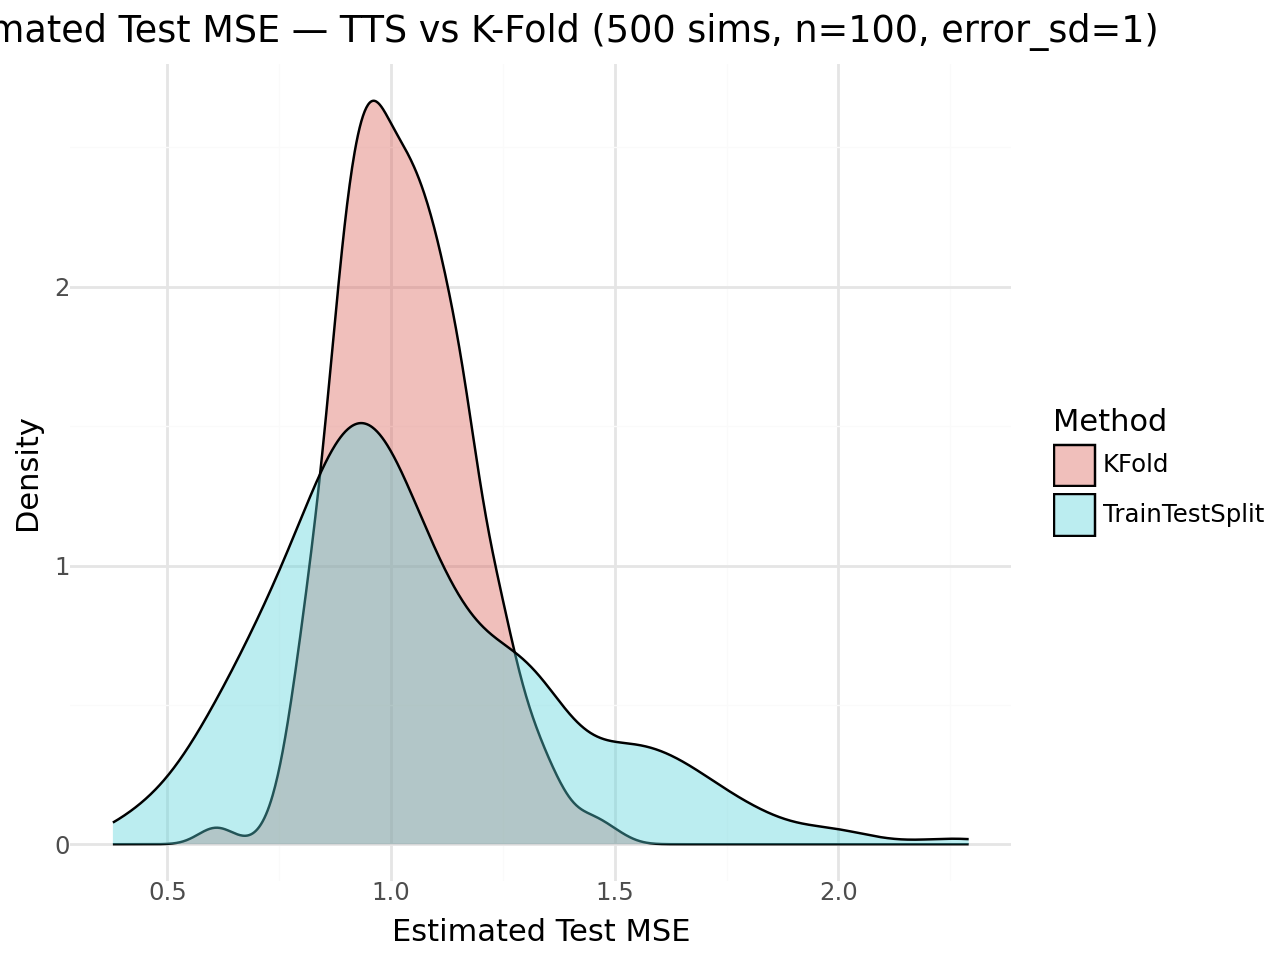

In [33]:
########## YOUR CODE HERE #################
p_base = (
    ggplot(sim_data_long, aes(x="value", fill="variable"))
    + geom_density(alpha=0.4)
    + theme_minimal()
    + labs(title="Estimated Test MSE — TTS vs K-Fold (500 sims, n=100, error_sd=1)",
           x="Estimated Test MSE", y="Density", fill="Method")
    + guides(fill=guide_legend(title="Method"))
)
p_base

In [23]:
print(
    sim_data_long.groupby("variable")["value"]
    .agg(["mean","std","median","min","max"])
    .rename(columns={"mean":"mean_mse","std":"std_mse"})
    .reset_index()
    .to_string(index=False)
)

      variable  mean_mse  std_mse   median      min      max
         KFold  1.032459 0.144014 1.021605 0.599373 1.505118
TrainTestSplit  1.050926 0.325258 0.987300 0.378269 2.291219


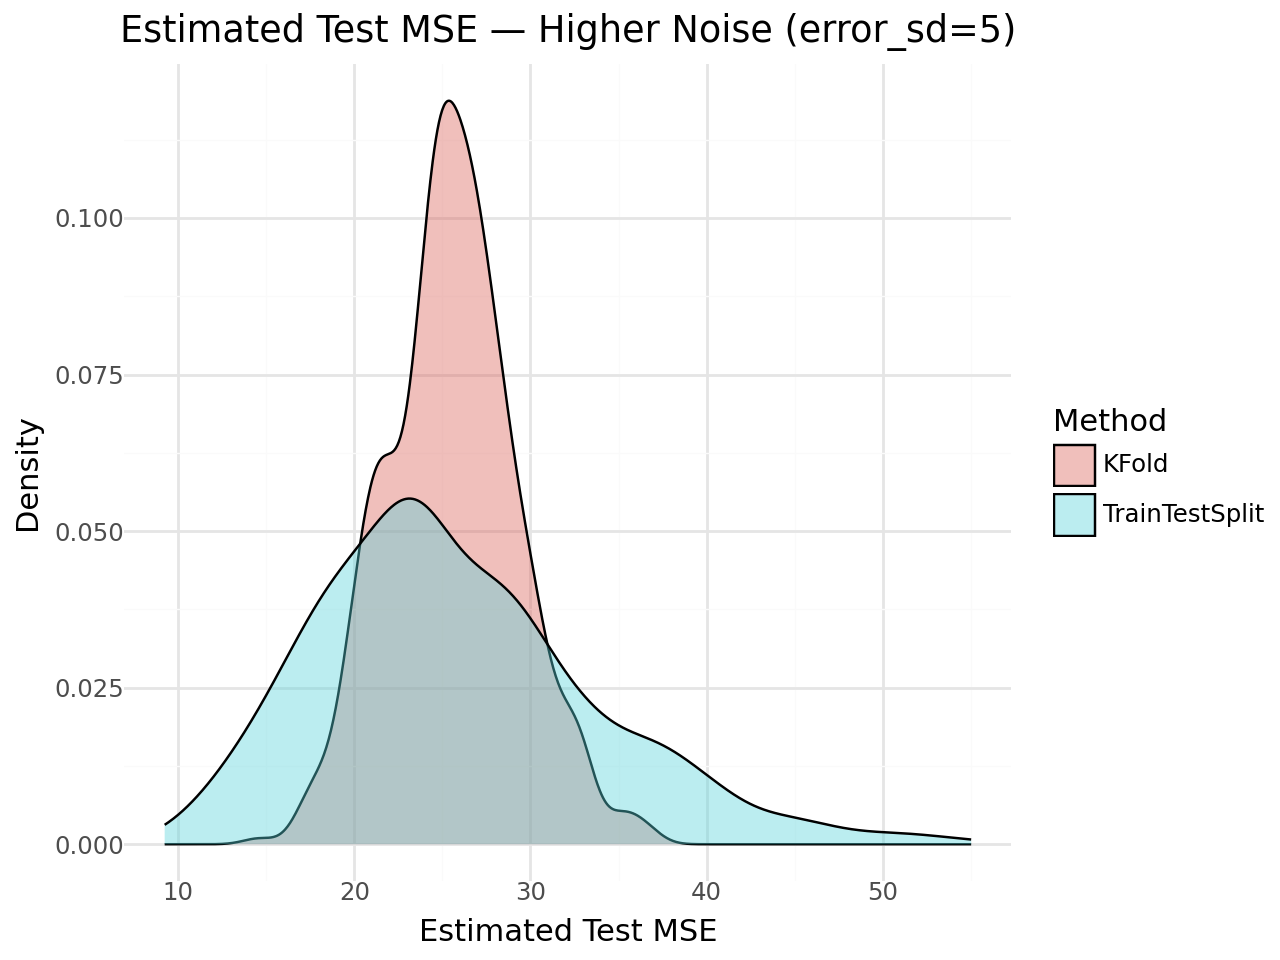

In [25]:
# what if #1: higher noise (error_sd = 5), same n and k
sim_hi = [modelValidationSim(error_sd=5) for _ in range(500)]
sim_hi = pd.concat(sim_hi)
sim_hi_long = pd.melt(sim_hi)  # -> columns: variable, value

p_hi = (
    ggplot(sim_hi_long, aes(x="value", fill="variable"))
    + geom_density(alpha=0.4)
    + theme_minimal()
    + labs(title="Estimated Test MSE — Higher Noise (error_sd=5)",
           x="Estimated Test MSE", y="Density", fill="Method")
)
p_hi

In [26]:
print(
    sim_hi_long.groupby("variable")["value"]
    .agg(["mean","std","median","min","max"])
    .rename(columns={"mean":"mean_mse","std":"std_mse"})
    .reset_index()
    .to_string(index=False)
)

      variable  mean_mse  std_mse    median       min       max
         KFold 25.584614 3.626984 25.503702 14.575195 36.848693
TrainTestSplit 25.707830 7.973847 24.256116  9.226755 55.026662


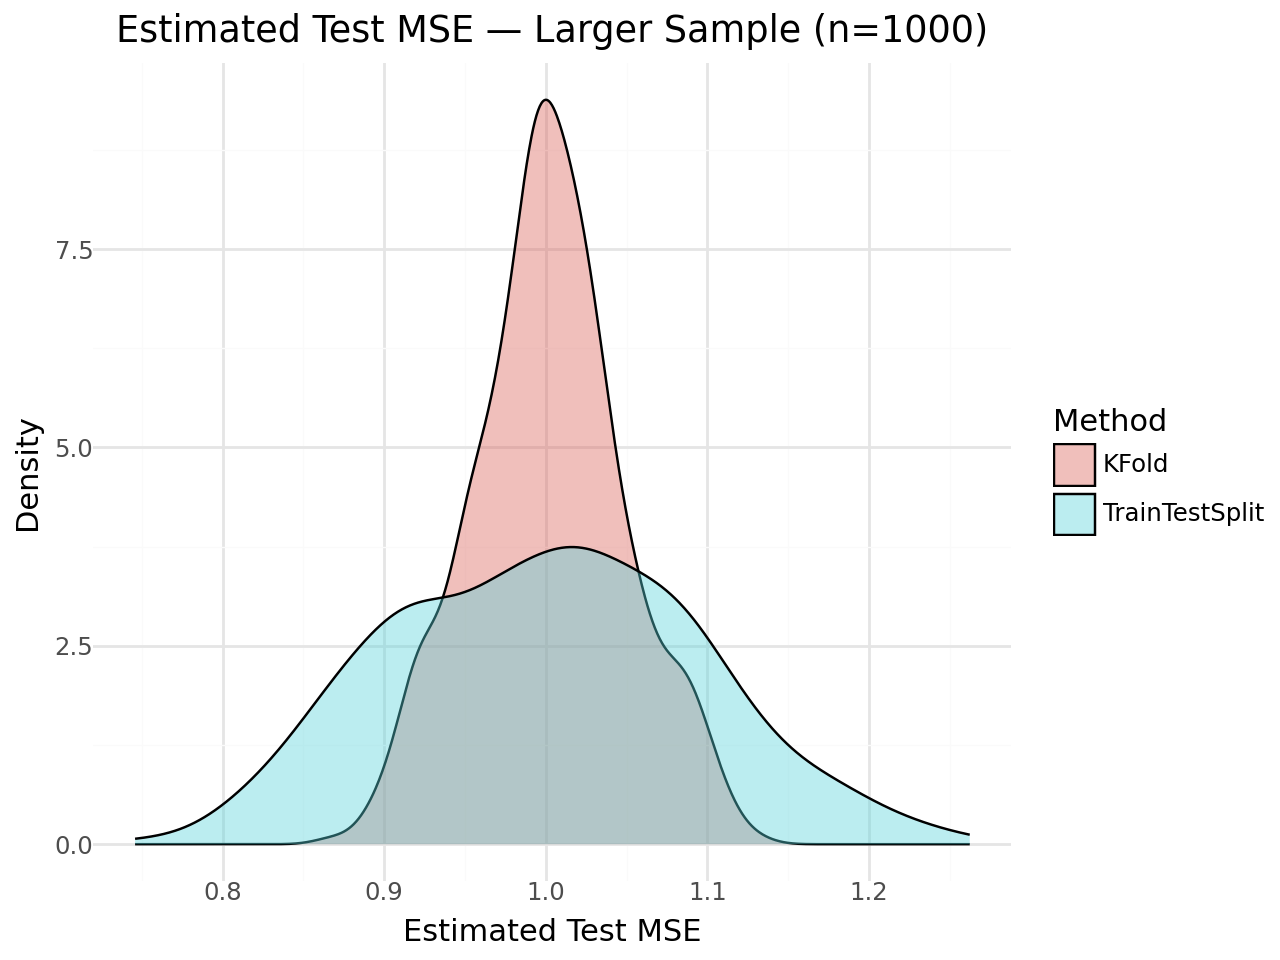

In [29]:
# what if #2: larger sample size (n = 1000), same noise as baseline
sim_big = [modelValidationSim(n=1000, error_sd=1) for _ in range(500)]
sim_big = pd.concat(sim_big)
sim_big_long = pd.melt(sim_big)

p_big = (
    ggplot(sim_big_long, aes(x="value", fill="variable"))
    + geom_density(alpha=0.4)
    + theme_minimal()
    + labs(title="Estimated Test MSE — Larger Sample (n=1000)",
           x="Estimated Test MSE", y="Density", fill="Method")
)
p_big

In [31]:
print(
    sim_big_long.groupby("variable")["value"]
    .agg(["mean","std","median","min","max"])
    .rename(columns={"mean":"mean_mse","std":"std_mse"})
    .reset_index()
    .to_string(index=False)
)
###########################################

      variable  mean_mse  std_mse   median      min      max
         KFold  1.001771 0.046399 1.000169 0.868114 1.130143
TrainTestSplit  0.999605 0.095873 1.002035 0.745793 1.262369


## Regularization

Use [this web app](https://shinylive.io/py/app/#h=0&code=NobwRAdghgtgpmAXGKAHVA6VBPMAaMAYwHsIAXOcpMAYgAIAhbOgYQAs4AbAZzijoAKUAE6c4ZMoK5jhASzKyAOhGWyYqYsMkwoZVJ2JlOsgEZZs+w3Sjc6+ssuX0Akus3biAEwCuY2wDNNOhgvLlkIAHNVNy07KAhPG2tbVE9ojVjeKBNNCGS6bghuRwgXGMlCb24yYhhBbDI2UjoAMW8IQgVSAOFaugNCKE46f1kxZX9eupJ1ETg6NQyK2tQ5vAK1AH1EsigJqYK2cOZF9zoAQXR15whUbzJudYB5e7uH9YBlOG5uWVJ14R8TqyABucABlE8cGE628ShUpToOz2ECKalsAF46ABGAAMuOUvzqWOARO2uigAAoIBi8fiAJQjIKyBZ5YTxCJwSm49ZomDcekAXRKTms6GUaFQmzhdCxcKwUE5m1GAA84J5Kco6Nq6PQoJ5PHQOPq6I1dNZOAYAO62AAyUAAKnAABqm4h0EzzTyybj6KDYdV0EGyfgAWV0bAAUlAVVqdfLjZ5NiRyJQyJq8jqs-LdhFuBhuIQ5Kh03Gs+WCsJCBjFGA2BJUNxEAB6Zs6RoAKxjGGE1W83uIGBmzc4um+ZGb4ca0ZVGA73AA-CnRhEMU7nQBac6hj4b0Oh22bAASDoPmn3ttrZfL9Lw1+zsgwufzheLpczFaztdk-jolKt4SeMQVoYFOUYxoyYEzhgR7eGYACK3hwEhlLAAA5A6FjfOIaHrFB3awSYgr0gA3FeH43neFG3te8okJw3gwBAGafjiPL3jqIC1oQo4-LWiB0NxxCcBuMCeBueJ0PRG6cBEG4ABx2NgG4AKzBCqG5QPc7oUCqZAyXJhBptCppwHpMlwP4DhgAAvlRrH0A68jjBRD4YGw2KamAR7AXQAAixDfHQABKcARL4IiyAAXrofx5B8ZCApEjQXP4-hwJ0rCBWlsiELIaZ0AAotUahjoutY0a5Or0OEbwFMYULCNelVufRjHMRx2p4vZn5cUQvHFEgglEMJoniQA7Ip0myapSkbgALOpmnabWdmdbqdBOUYcDrfKtX3Js3ANdCLGsTqtZ7Pg61fmAXxiJl-CheFo5yDFXTxYllARI0iC1j1Z10LiGD4iDIPYv9Z3g9dOpA1DVUVtUcCoBiQO4nDAPagBniNDWYB0gApH960tZ+8qoKdAN9TxNiDQJtYlgtBQ6Jaq0Q6xtaUoVUCEGwppqPM2DEN4UlsBy8yNPMR2yI1rJvOsEsbDAEXvXQAGWqaUAANaS7U4v826dDCO0GD0kT8N0CT2qW3QdHCe1FPltiABMbOcdxA38cN01ydi2JzWpMAaVpNSs+t9BC3o9x2AYDjm-KEdvJslilmAycVRD1v0IVKp+tAKvxIa2eWICpl6YbvkASlZBWu6cAAI7eEMG5YylbVMcUFHyr0VoO61dtMb3n7ddD2pUx7Q1CSJM0AGz+0twfEKH5tuWw81eUXo553F6cjzbj7k7vN1XmAh86gA6hweRWuL7LhHQ4Y8+E8y2nwwgQOEETBKEPD9LI2u-xAV+hswqAh+HFR4-RiARB9AoQgp9tSAgiKA343R1hBEAd4dkwxAHV00JrCB18kTum4O6EwzAoSjHfpEawkCfgjHaMCUg8DrAJGCOENQ0UP6mlFpIAwdD-AMPehgC4tCAiCLigsWw-B4CJVykyJqy9PzwBsJgrhTQrR0EFpgr+UJhg+jsNCQIwgYBcKtBwEu1oTL6M9BIaEwiWiaGYWZWA+hwT3z4PFBucxC7CF6MISRNC+FiI6CrM02g+DcEwUFBW3AvGAjSIois3pqjxCMn+ZoUAwTsk5IyGx19KA0JCLotCthwrfF4FI1hCtEpISDEMJC+Zj7kQxhbV2FZ6D2nXLvMmXkAAkvSdyFVlIJRQozJjcxANiGyIAIA2RGaMyJMBNggFkLSGyAA9GZczKQAE1Ngsg3CMnhIAdk2X2fSdZTt+k70SXvLAg8AZNJPrcrMT0IqvVis0Guwh8EemYPqb01D+CoEoEMMgzAajcPmEE+hISJF300I1ZhkKQXQGMFFaFIhOQ6K4HEdkMjoT5joDcOgton4iBCiA8pcV5YcAMWi8FzDwhFgiUFMxBSYnRXmMQX8CsSCWVGHlNMthmWAhsN8YRDAMpaV4FC0RzCBFwuaPonQUIbaoDoDy00NduEfybHKzQshoFotEbCxheRKQK0GW0s65i4CMgLnK1FYLsDrFQPE3KNRezBCqJINCdx1YS1kP46+Rr6xoT+cAnweVIjIrpYMuglAhYRF5pCz0dA0LfMaBGhWzrODguEQ6I4thBhVCCtwZmnBYTv3KPEWOLSszuvVJ6zQthIWizBEzIYwwggYt6FJbKgr8rkEaSfMdu9rasR6cwp5zDbTnA+B8J4f5bTYgdaw4K0tsWUltE7B1JdcEDpgCEPIRj+Sat-G8l60VPkQGEfOxdTxmEAqkfSl1BsFYwsVeayNuxNZcIVtkEhDEKB1IYty38QI2DMNWPi8Q0Jmz8pykK8g6xHUAoAxwOo3a3ScglsIYRm7PDYpfdYGDoL80Qp0nSr94jmhkI1v+6hMS4kQcTdzaDLydSwdgPB4QiHB25WHWQNDrCMPMawxaYYNQ8PmIwLO25k7PwdMdC6bp+8HlnVrP0h9S7hmjLGeyQgkzpmzPmYoRZyzVlTM2WZ3Z+y6CHNGcc055zLl0AANTmdHDAEwiRzPtEaiYIzcAuIGcsyADsazNmoDmQAHwM4oGxUBNgdji2cxLukyAgDzeCmy1znktKUxWadXHtTad6UR7FWJEvjOM1MrZ5mIvWY2Y1+zByjm6BOWc2QFynaee87APz-BEuBehMF7moXEsRaizZnLczEvJdS5cjLBmss5Yo3lgrE6bVuQPmV4aTSDsXwKVULhiD3k3veusQhStqgi2IMQWVCsLvXrehI6oSVvqcYbTqSkvBJbHX8dkYgYJGRmNyrzfR-AICMU9P4sJBRBh+CNL5UWvY2CcGYNfcjaKuXCOcL+W7vgFD6AhXS3LzAGM8m4boEpcruC8fyBAKwHaP7PrfZR6wkhu2Sqjj+VW8wlb5tkGTp1m2qfMBUviWl5oa6+ASb97UeauVOpELxig3r+Axy-oCeT47CsY2K+WadYBrkGZ88N8z62AkvbCpd97zRPtfUaBgfLvSbmsWttbLuwFNO2wYgPXew9bljxpp7SeBkNyzxwLNQOy0Q62V2-GR8q9145wMICT3GMEwqS8iwFYkVqG6aeOsKrbjHVksARSp6yDt5gGN3tzT7MDfMLPvIVNdKpYy3NLDP8CsKFaXzYyAwxBNbc7lTkDPVhzTVOIBqnlcb5irE5IW4thxgJtrpUhodwqRgHDpLiRWytAzIgKOIIlDiFFK-YzzJEFJz+SAVmhEEwEuDcAjZSc46xCrXGeOsAAVXWB2XWDPkZCAiNEyR1ngGYUBFHHem4COA1Urk725XuBmHmEpGdEZERyFn8SKVxX0SbW9GBEiGEXOEgI7hv0-SxXHETTSgyif0viKj-zoFLzoCALoB2RYUNEoW7WYDPkoIZ0rXHCcQYMymaGdDX3mALyKFIDrVsEpAYDwBYDwD8jwAAHE8Ajw8BIw8AABpRkDteYIDO2CgLHOgFneg9KCQhEG-KQhTIrZPbUU3W0R7cfWfOlDQ9kVAXmdDbgcfLRXsLgXlDgWVBucccBX6BvZwu5Z8DAXwZvUmR8eI4wJIx5VvA7ViC+SHHFYYHdclGEUlBdJdMvLde1UyBINtd0YwuVI4FNUQrIz8HfITYVBcOgC+c0ICaJdfcw4YLRawHIKOBWEESKIWKgm-T8XLfKWwKDPIyghcRwpXRvZIp8RUfMNI5hI+cdJoisToyQUWdASgaouVEvAdAVVokdeROVWQkhaAcgLYqYj1ToVtP8BgDcQw1WI4O-WoqwsVYYAVRgzVPIZ0RYzIm-FYkrFI9YjATY3Yw7HYyYz8ItZ+QongkKcorKC4lDB4SBMfRWMYClIxKFR4isW4+Qq4pQj43JKOMxOnWwKWFNIwchH8dKJKSQPJOADlLDRY+ErMfYohHo2faQTRIWQYiOL480cvTnBQIKICMEo7CE2ItyVI2QdIrTcEpE8sc4A9GjWg-xQEzoRQ84DcZwB1cQigQ0b0Bg9kiws0PICWUk8sCtbtEyQ03EykJ4DcMAr4gpAY0VVlOVK9SKR3OwrUrMBKL7RoBUxE5Y2IyEu5NgPPWsAvWYOQahPyVk6EAqYMj5FWSMl3NgQaBM0rG-JY37AAOWAlhF+Ak0B2lhMk8PFnnwvTV05HWB5jFiDPtze1vWYQLOSjYELWEGYFGPAy33NDmCDGhGYGtHWAIPZAoFE0NCyWYHqKHPLLOhLI01rDcPxKbLoG8LQD8LEwCNFMwV4E4FCOwjoAiJKm6GiO3LWLzASM4HVJVJhLhPDM3JvwFMONRROIVjOMdWlIIJ-nZQdLpVzKu23nhIHO+wCSGBCHu1xBjOaTjOYRzE-LVKdJ-KVz-MlGOI-TpTOLAvpxaJxNsAgpJPhOgtDLoHgpSn0VXKNDDTQsN1+wTI-JfK-K1Lwt+wClOLRNr2pWaAouExLVFkiHmGooGM7OkqdLotvQYs+kHPaMpAFxIRuzYFdQWF-BZxEy+OYAMoXFNk1M4vjJtW9whnDleCjmTgZKRnV0tMjX+OsMYMUNf2vh4FvHRL7WIA3HdMUJTDuIUNNk7kfDbg6nNmdhtTDz4gnhGinh9j9ljwDiDm0lLn0iMlTCaiT12lTydi8gEBjlsC+B4xcoYwADU38f5HVyT7iHhs8rYIYA97Z1pYr1p4raYvZRoZpfZggTBZpUAhr0qE9F58q45HwE4Dpk4vJk4qqngz5CpbQPhmqTdpq7KyAk4Y55qY4WAngKyl0KzzgKyHQ1qYjmoqJwqSgKFz9hAskNLbh7gBIbg3gIEZqyABIXhI53hz8wFSABIvgAaIB6RfoKJ6AxVgRO0WAhhCBadJAjYihijH0yjiMK9WEq8gEwLbBmhORAFFzT8KRrwAABKGhQMEDAWGzgOBCiO6nGykMG9aMkIYXw-gEkGYWDLkTwfwNDTgNmjEfaMgDAKkekRkYknm1kRWYUc2Fm-m0WYZVIIcUgQYdMOWtmm682QEMgTBPIdW0WEoLMWy366OKwLVHDIkZWCRcS4VUmz60mpKRqLAXa8KrMO6uapm82egPDe-XYffPocm0EGQuG5mrYVmhWrEBmzWhyKSMVUDZOdEnQaAEjccDgWBCYisFcNDFURW-NAsOCByxm9aGMfrLEQofMKfOa3eFUXGFMXjQaWI7AWu7KBu3eNgJCXGMCs2FpZEDEfWqAWImMDEGMWIxFaEDEYAGdMAc4bupXWsQqWe37WsZwRehtWsJ9K6A7WsAA1elpWsHZXejGWsM+Q+jIhgU+jUlgC+lvPya+z8WsDQu+isWsI8J+8sWsSMN+m6fQt+wUKy9aCQfTMAAvbE4TIqEqdsNlZg8O9m4aAbT7J6t4EWxm12z8EugscQSkFUUcT0TgXGP6TRHBrgXGEB5DMBqq+pHafAPmbaDECQVBisbW3WkYI1Q26qTVLa02yQc29WS2+A62wTSiv8Ly9-YErHBhugEm+2iiMmyEOxD268d2mORa5a1axm8GmOn2s-SYAOoECm4Omm0OpZGB4ZKO9aERn+EkPIO+Se6egh+e+xsAFe6h9exxnelxsAA+jxk+sAQUa46xvWsO+WqAZW6AeAbgGW1ifuzYKq4Zfu2E4gQgYACxiJth9pWOvgeOnXR1JOxUEw1O8QXKDO8sLO6wHOrEewfOkwQuiRrMEuuJooDASu3a6u5usJ74N+puoSSyVu25duuATu7+N+3u6Jqqwemuke3eMe4QCe2sGejxhejx5x9YVxjx9xlZzxxxnxv+4mAByQGrMAFRlarEshgqYqBQSBqi6B4JoB+BxKRB+4ZBsW4ulUJ2DB9MbB7IYh4+dYbAIhvBlMwR8hyhghhQWh+h9aJht+FhqIMM7UY2uqBOnh4YPh5Sm2ykkKik3E0gcRu2rah2uRgjBRumyyLhg6o6w606869RsOOgLRh-HRuoQOmGkO2WoJtm0x7+bgIuuF8sTFxqzEOgSe25AJoV2sc+jxq+jx2+jxx+jx1+jxz+jxn+3x-xqW+Juu8J9aSJz8aJlgOJ9l0WBJpJ-lhQmW2lllMcLhxO+IPJ6wAp9O9aUpmMXO4WyJap0qnl1iepsuxp5pwwdUmuoSdp3plpLpkaHpt+-pwZ3RYZikPuw1lLVQ3eIeyZ25aZ2ZsACVjZqVjZmVjZuVjZhVjZpVjZlVnZ82WpnUQBg58l46qlk53fcgcBi5sqX0vIExg5u54QB54W0Wqt7UdB3gD5-5-B6hv5r5gF4BoFgqCh8DUF5yAZiFrW8QZhlcEUaAdAYZS4cmSUaUWQdYXgB66EcKpPcAdp6gTmuYcwfAEaVMKgZAU4WIWHdQf5WwW4dIM4VYBIJIJIVIfYPoAIsQEQO9YwavYQTYMChYcoUlQokSkGtG9s0lGmYgH-XiWBCs8QEoegChJ+M1BA5QO6skZEakWkEGT2o2ylIYOgChuQbIPwa8CgrEW4HsAuWoDAFnYxIYbkdYcGSwiRoZZjzAdkBIdjzj5mHjnEXkCR5wYZFjkToCGADjzQCTmnPj0G68ZdIT1j0TpT8T7jtT6T68AAuT4TtjvTlTgz3joziibg7ThTsTyzt8wz-j68QQ+z8z5Trj5z6z1z3l+gAAiAOAscQ0WjkMEwBjiiBgUznTxTrz1T3zjTiifVjz3T+LqzqTvzrMPyGLhziz7zyT9TiRjQ3Lzz-TnzzLpLrMI8UrtL8rwrmzrMSMWruL+rlzqrnUfQlrxzgr9r6O9h9FpqiiWB52DAAAZnmmvHmCxHkgwCdjG+vBZCxHGgwHkgW4ondCxBUgwGdlomGTG4wHmnkmvGYCxDeYAE5xprwNEsRsRxvjv-O2D0DdZrxXQsRNM6R1ovMKCAAqMjc2LzIZP7naAH4lOgP7+EViLzZdP7xeUHkzv77wL7rg8HzRZHwQv7q0ZH+TsrpzwrlSRrnUfr7UN7v8V0Q5Fj5RZibAxkZsSwzAaoDUbA+FugKKDcQsTQeYZ0a8egBWQwcxOpOjiLoKIYMVTwNcqAwpDxVso-R1bgQ0LVbENJjaPyB-FoODRR38CpzwDAVX3YdX3jTTLiW5OZz2b-XeBxoaX-C3pxz2ZwWI1Z76h3sAdxgSIAm3iVgSZQm3qVgSZNk3sAGVgSdQm3uVgSLQm3hVgSHQm3pVgSPQm3lVgSfQ53rxgSEAm3nxgSM+Z37noaZ0G1GyZqa8KFvIHmjdu6q9wESkHmvmgWtdDRnUdKc0EkU3jx7N4aXN4afN4aRZgtxx4t4aZZ4aDejZ9Z4aUt4aFVjZrxjZ7Z5X+gMD1+a8TgfxLELGkQeDlBZiCR1fjAUYdMHm4AZvsgP+pEfwWxvP4iFfiDkgYZPfpDTYBf-oFDlflD4Ze0H4YgSkGB4e4J9YA-vslypGQSwa4I2G4hqB4NUYoMNGPORjD7JNcZHUGLvxQ7795ANfC-ifzP5H9awV-FAV-2TCbcX+X-ZWpZCf6Pc5A6NEvpiSxDl5NMv-HmgWEOJwBgAuIPxn9xgYAD5AQAzXCALIBgCkI8sYSCjGBgwC+OOgFUAgPHqH58QxfCiJQNXwH8MBx-TJtgIv64Daw1-eQeUUIHDIFBcAUgf4HIHXhNWQULECf1R7rcswSGQVixxTCq1QUFAVCKv0IHrABoxAVwYbB0EkAtB14KDvZyRiZNNMLHEQOyGwCoRdyhRRxiXkcbl5NBxuYAGIGYgn9fKSQykCkLcGUB0hmTIUDahjA+gUYGcZXpLW1668KQBveAJSCpjyEtWQ0UwRAm6b+AeqNgjZl3SGhgUbIxPYBDrWhbl8IAtkQUEAA) to play around with the regularization strength of the models. *MAKE SURE to scroll all the way to the bottom to see all the graphs*.


### Questions
With the slider at 0.1 (the default) look at the boxplot at the top of the page. This shows the coefficients from 1000 simulated data sets. For each data set the 'vowels' (A, E, I, O, U, Y, W) do have some relationship with the outcome (X) that our model is predicting. A has the largest effect then E, I, O, U, Y and finally W has the smallest effect on X. The Consonants (B,C,D,G,H,J,K) have absolutely no effect on X.

Look at the Graph and ask yourself these questions (questions also listed in app).


#### Comparing LASSO, Ridge, and Linear Regression
- Which model (Linear, LASSO, Ridge) tends to have the highest coefficients? What does this tell you about the various penalties each model has?
- What happens to the LASSO coefficients for the Consonant predictors (B-K) which have no real effect on X?
- The Linear and Ridge Coefficients look similar for the Consonants (B-K) but what's slightly different between them? What does that tell you about what Ridge penalties do?
- Are the larger effects (A-I) affected differently than the smaller effects (O-W) when you increase the Regularization Strength?

#### Comparing Different Regularization Strengths

Now, using the slider at the top of the page, change the Regularization Strength. Try values that are very low, moderate, and very high.

Look at the Graph and ask yourself these questions:

- What happens to the LASSO and Ridge models when the Regularization Strength is almost 0?
- What happens to the LASSO model's coefficients when the Regularization Strength is very high?
- Do the Linear Regression coefficients change when you change Regularization Strength? (if so, why, if not, why not?)

Answer: Linear Regression tends to have the largest coefficients since it doesn’t apply any penalties, while Ridge shrinks them toward zero and LASSO can shrink some all the way to zero. For the consonant predictors (B–K), which have no real effect on X, LASSO drives their coefficients exactly to zero and essentially removes them, whereas Ridge just pulls them closer to zero and Linear Regression leaves them as noisy non-zero values. When regularization strength increases, the smaller effects shrink more quickly and may disappear first, while the larger true effects remain but still get pulled down. If the regularization strength is almost zero, both Ridge and LASSO behave like Linear Regression with big unpenalized coefficients, but when the strength is very high, LASSO forces most coefficients to zero and only keeps the strongest predictors. Linear Regression coefficients don’t change with regularization strength at all since it doesn’t include a penalty term.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = 200px/>